# Seasonability

In [18]:
def decompose_absence(dfs, value_col='Total_Lost', samples='all', period=7):
    """
    Decompose a daily time series into trend, seasonality, and residuals.

    Parameters:
    -----------
    dfs : pandas.DataFrame
        Your daily dataframe (e.g. df_grouped) 
        with a 'Date' column of type datetime64[ns].
    value_col : str
        The name of the column you want to decompose (default 'Total_Lost').
    samples : int or 'all'
        How many recent samples (days) to use for decomposition.
        If 'all', use the entire time series.
    period : int
        The seasonality period. 
        For daily data with weekly seasonality, period=7.
        For monthly ~30, for yearly ~365, etc.
    """
    
    # Make a copy if you don't want to modify dfs in place
    df_copy = dfs.copy()
    
    # Ensure 'Date' is a DateTime index
    df_copy = df_copy.set_index('Date').sort_index()
    
    # Grab the series we want to decompose
    series = df_copy[value_col]
    
    # If we only want to decompose a portion of the data
    if samples != 'all':
        series = series.iloc[-samples:]  # last N samples
    
    # Perform seasonal decomposition
    result = seasonal_decompose(series, model='additive', period=period)
    
    # Extract the components
    observed = result.observed
    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid
    
    # Plot the results
    fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
    
    axs[0].set_title(f'Observed  Total Lost', fontsize=14)
    axs[0].plot(observed, label='Observed')
    axs[0].grid(True)
    
    axs[1].set_title(f'Trend Total Lost', fontsize=14)
    axs[1].plot(trend, color='orange', label='Trend')
    axs[1].grid(True)
    
    axs[2].set_title(f'Seasonality Total Lost', fontsize=14)
    axs[2].plot(seasonal, color='green', label='Seasonality')
    axs[2].grid(True)
    
    axs[3].set_title(f'Residual Total Lost', fontsize=14)
    axs[3].plot(residual, color='red', label='Residual')
    axs[3].scatter(x=residual.index, y=residual, alpha=0.5, color='red')
    axs[3].grid(True)
    
    plt.tight_layout()
    plt.show()

# Decompose weekly seasonality (period=7) & ACF & PACF Analysis

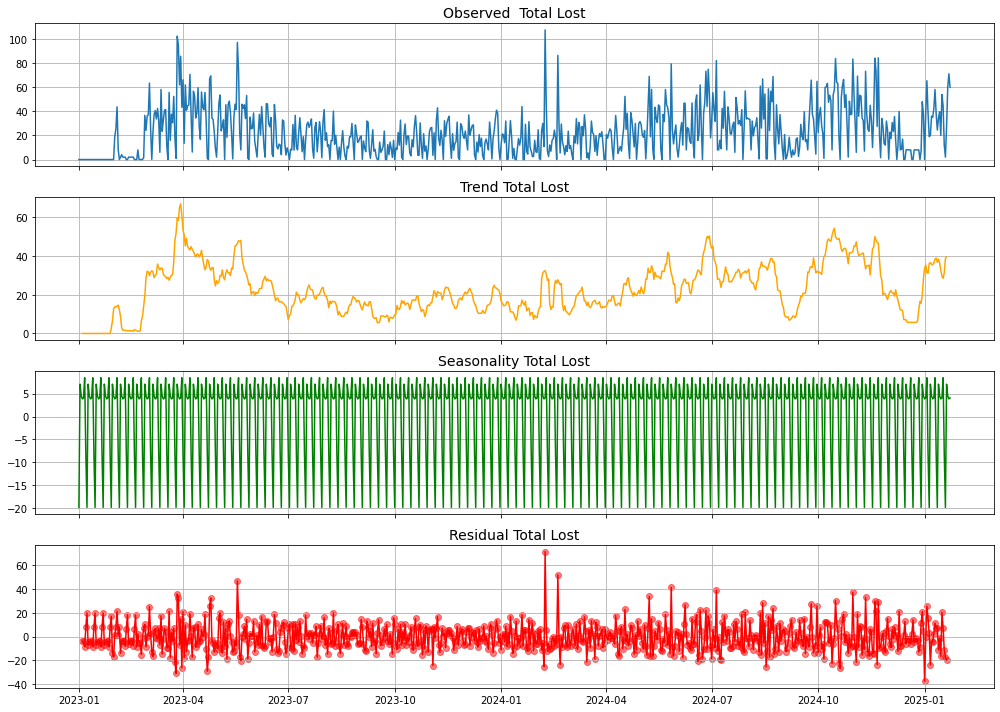

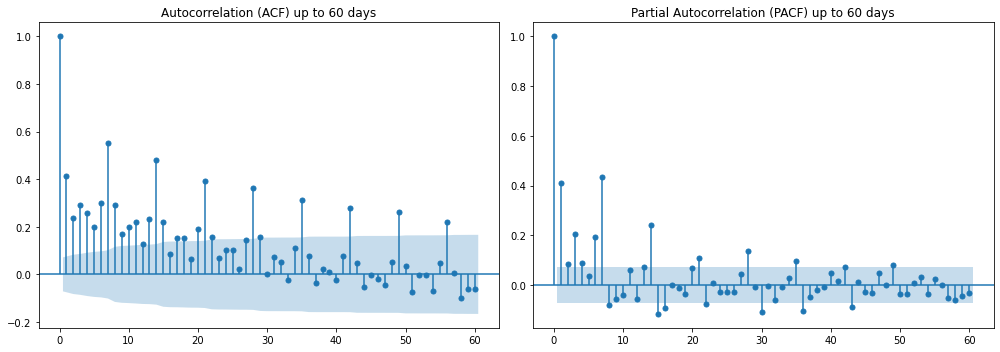

In [19]:
# 1) Decompose weekly seasonality (period=7)
decompose_absence(df_grouped, value_col='Total_Lost', samples='all', period=7)

# 2) Plot ACF and PACF side by side for up to 60 lags (about 2 months)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(df_grouped['Total_Lost'], lags=60, ax=ax1)
ax1.set_title('Autocorrelation (ACF) up to 60 days')

plot_pacf(df_grouped['Total_Lost'], lags=60, ax=ax2)
ax2.set_title('Partial Autocorrelation (PACF) up to 60 days')

plt.tight_layout()
plt.show()

# 📊 **1. Decomposition Analysis**

### 🔍 **Observed:**
- Our **daily Total Losts series** shows considerable variation:
  - **Spikes**: Total Losts values occasionally spike between **80–100**.
  - **Baseline**: Fluctuates around **20–40** over extended periods.

### 📈 **Trend:**
- The **Trend line** gradually **rises and falls** over several months, suggesting:
  - **Long-term drift** possibly influenced by:
    - **Business cycles**
    - **Policy changes**
    - **Workforce dynamics**

### 🔄 **Seasonality (Period = 7):**
- The **green seasonality plot** forms a repeating wave **every 7 days**, indicating a **weekly pattern**.
- **Amplitude** ranges from roughly **+5 down to −15**, implying:
  - Certain **days of the week** consistently have **higher or lower** Total Losts rates.

### 📉 **Residual:**
- The **red scatter/line** represents what's left after removing **Trend** and **Seasonality**:
  - **Fluctuates** between **−40 and +40**, with some **extreme spikes**.
  - Indicates the presence of **additional drivers**, such as:
    - **Holidays**
    - **One-off events**
    - **Group-specific factors** that aren't captured by a simple weekly seasonality.

---

## ✅ **Key Takeaway:**
- We observe a clear **weekly seasonality** (**7-day cycle**).
- There’s also a noticeable **long-term trend**.
- Our future models should account for both using:
  - **Seasonal terms**
  - **Dummy variables for the day of the week**
  - **Other time-based features**

---

# 📊 **2. ACF & PACF Analysis**

We plotted the **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** for **lags = 60** (covering ~2 months).

### 🔗 **ACF (Autocorrelation Function):**
- **Lag 1**: A **large spike**, indicating that **today’s Total Losts strongly correlate** with **yesterday’s**.
- **Weekly Pattern**: Noticeable spikes at **lags 7, 14, 21**, etc., confirming the **weekly pattern**.
- **Monthly Effect?**: Smaller spikes around **30 days** may suggest a **monthly trend** (less pronounced but worth exploring).

### 🔗 **PACF (Partial Autocorrelation Function):**
- **Lag 1**: The **largest spike**, highlighting a **strong direct correlation** with the **previous day’s Total Losts**.
- **Lag 7**: Another notable spike, showing a **weekly effect** beyond just the day-to-day correlation.
- **Higher Lags (14, 21, 28)**: Smaller spikes, suggesting that once we account for **lag 1** and **lag 7**, additional multiples of 7 add **less explanatory power**.

---

### 📈 **In General:**
- If **ACF remains high** at lags like **14, 21, 28**, but **PACF is low**, it implies that these correlations are **indirectly explained** by **lag 1** or **lag 7**.
- Spikes around **30 days** hint at potential **monthly patterns**, although **weekly trends** often dominate in business contexts.

---

## ✅ **Key Takeaway:**
- The time series has a strong **autoregressive structure**:
  - Depends on **past values**, especially **1 day ago** and **7 days ago**.
- We can enhance model performance by introducing **lagged features** such as:
  - **Total Losts_{t-1}** (previous day)
  - **Total Losts_{t-7}** (previous week)
  - Potentially **Total Losts_{t-14}**, **Total Losts_{t-30}**, if data shows benefits.

---

# 💡 **Final Thoughts**

### ✅ **Key Conclusions:**
- **Lag Features Are Applicable:**  
  ACF and PACF confirm that **past Total Losts values** help predict **future Total Losts**.

- **Critical Lags Identified:**
  - **Lag 1** (yesterday’s Total Losts)
  - **Lag 7** (Total Losts from the same day last week)
  - Potentially **Lag 14** or **Lag 30**, depending on model performance.

- **Seasonality Confirmed:**  
  Seasonal decomposition reaffirms a **weekly pattern**.

### 🔍 **Next Steps for Modeling:**
- Introduce **lag features**, particularly **day 1** and **day 7**.
- Consider adding:
  - **Explicit day-of-week features**
  - A **7-day seasonal term** for time-series models that support seasonality.

> 🚀 **In summary:**  
Introducing these lag features can significantly **improve predictive accuracy**, ensuring the model captures both **short-term dependencies** and **long-term seasonal trends**.


# Decomposemonthly seasonality (period=30) & ACF & PACF Analysis

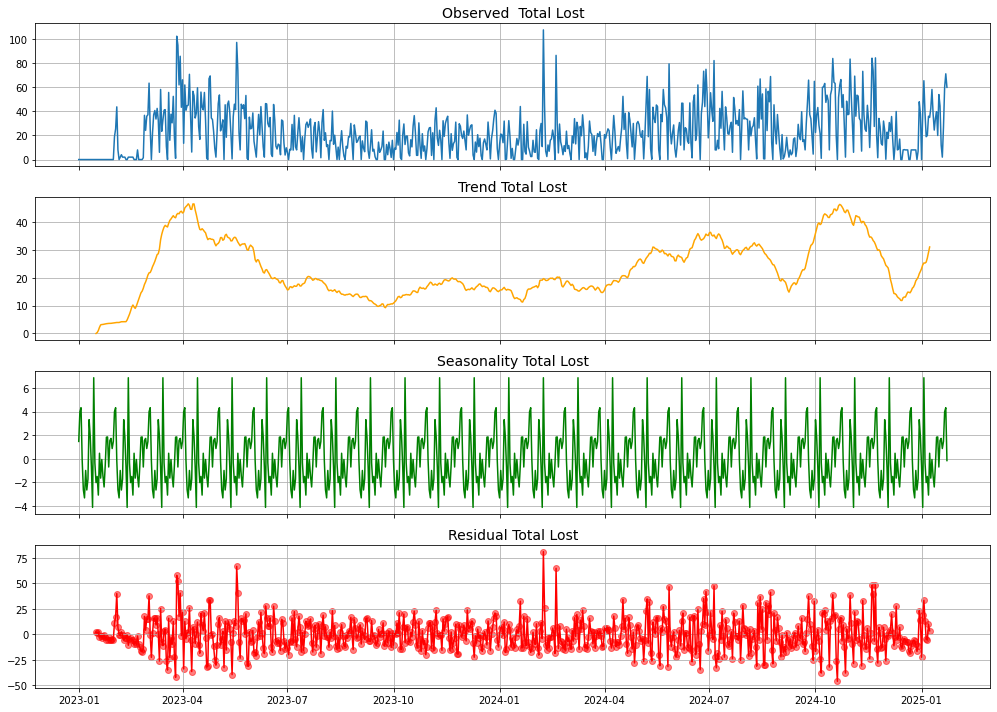

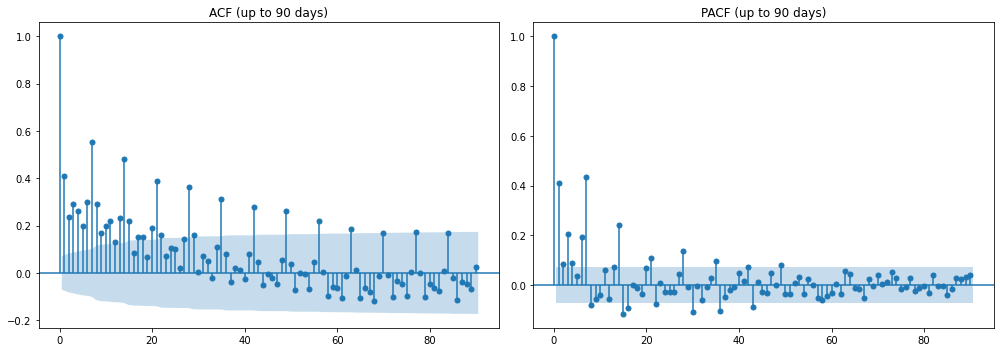

In [20]:
# 1) Decompose monthly seasonality (period=30)
decompose_absence(dfs=df_grouped,  # or whatever your DataFrame is named
                  value_col='Total_Lost',
                  samples='all',
                  period=30)  # approximate 1-month cycle

# 2) Plot ACF and PACF side by side for up to 90 lags (~3 months)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(df_grouped['Total_Lost'], lags=90, ax=ax1)
ax1.set_title('ACF (up to 90 days)')

plot_pacf(df_grouped['Total_Lost'], lags=90, ax=ax2)
ax2.set_title('PACF (up to 90 days)')

plt.tight_layout()
plt.show()

# 📊 **1. Decomposition Analysis (Period = 30)**

---

### 🔍 **Observed (Total Losts)**
- The **daily Total Losts data** continues to show **significant variability**:
  - **Spikes** near **100** and periods closer to **0–20**.
- Compared to the **weekly decomposition**:
  - The **overall shape remains the same** (as it’s the same dataset).
  - Now focusing on extracting a **30-day repeating cycle**.

---

### 📈 **Trend**
- The **orange trend line** reveals a **long-term, slowly varying pattern**:
  - **Rises** from near **0 to around 40**.
  - Gradually **declines** toward the end of the series.
- This suggests influences from:
  - **External factors** (e.g., policy changes, business trends).
  - **Seasonal workforce dynamics** or **general workforce behavior** over **months**.

---

### 🔄 **Seasonality (Period ≈ 30 Days)**
- The **green line** attempts to capture a **monthly pattern**:
  - A **wave repeats** approximately every **30 data points**.
  - **Amplitude** ranges from about **+5 down to −1 or −2**, indicating:
    - Certain **days of the month** systematically show **higher/lower Total Losts** rates.

#### 🔍 **Comparison with Weekly Analysis:**
- The **weekly amplitude** was **larger (±15)**.
- The **monthly amplitude** is **smaller** but **still visible**.

---

### 📉 **Residual**
- After removing the **30-day seasonality** and **trend**, the **residual (in red)** shows:
  - **Notable spikes** ranging from **−40 to +80**.
- This indicates that:
  - A simple **30-day cycle doesn’t fully explain** daily fluctuations.
  - There are likely **other influences** such as:
    - **Weekly effects** (day-of-week patterns are strong).
    - **Holidays** and **random events**.

---

# 📊 **2. ACF & PACF Analysis (Up to 90 Days)**

---

### 🔗 **ACF (Autocorrelation Function)**
- **Lag 1:** A **large spike**, showing a **strong correlation** with **yesterday’s Total Losts**.
- **Weekly Patterns:** Ongoing spikes at multiples of 7 (**lags 7, 14, 21, etc.**), confirming the **weekly cycle**.
- **Monthly Signals:** Moderate spikes near **30, 60, and 90 days** hint at **monthly correlations**, though **less pronounced** compared to weekly lags.

---

### 🔗 **PACF (Partial Autocorrelation Function)**
- **Lag 1:** The **dominant direct effect**, meaning most of the correlation is with the **previous day’s Total Losts**.
- **Lag 7:** Shows significance, consistent with the **weekly pattern**.
- **Lag 30:** The **partial autocorrelation** is **smaller**, suggesting:
  - Once accounting for **shorter lags** (especially lag 1 and lag 7), the **monthly effect** adds **less direct explanatory power**.

#### 💡 **Key Insight:**
- **ACF** shows evidence of a **monthly cycle**.
- **PACF** suggests this monthly effect might be **indirect**, influenced by **weekly patterns** or other variables.

---

# ✅ **3. Key Takeaways for Monthly Seasonality**

### 📊 **Insights:**
- There **is** a **monthly signal**, but it’s **weaker** compared to the **weekly effect**.
- **Residual noise** remains **substantial** after accounting for the 30-day cycle, indicating **stronger drivers** (like weekly patterns).

---

### 🔍 **ACF vs. PACF:**
- **Minor correlation spikes** near **30 days** in the ACF.
- **PACF** for those lags is **not as large**, implying the monthly pattern may be **partly indirect**:
  - **Monthly patterns** might result from **accumulated weekly effects** or **external variables**.

---

### ❓ **Should We Use a Monthly Lag?**
- **Yes**, we can consider including **`Total Losts_{t-30}`** as a feature.
- However, the data strongly suggests that:
  - **Weekly lags** (**`t-7`**) and **lag 1** are **more critical**.
- Given:
  - **12+ months of data**
  - **Business relevance** (e.g., payroll, scheduling, monthly reporting deadlines)
  
Adding a **monthly seasonal component** or **monthly lags** could help, but it’s essential to **experiment** and assess if it **meaningfully improves model accuracy** compared to using only **weekly or daily lags**.

---

# 📊 **4. Overall Conclusion**

---

### 📈 **Comparing Monthly vs. Weekly Decomposition:**
- **Weekly patterns** and **short-term lags** (**1 day**, **7 days**) are **more dominant** in both:
  - **Seasonal decomposition**
  - **ACF/PACF analysis**
  
- **Monthly seasonality** exists but is **less pronounced**.
  - We may capture this with a **30-day lag**.

---

### 🚀 **Modeling Plan:**
- Start with **lagged features**:
  - **`Total Losts_{t-1}`**
  - **`Total Losts_{t-7}`**
  - Possibly **`Absence_{t-14}`**
- Test whether adding:
  - **`Total Losts_{t-30}`**
  - **Monthly dummies**  
  Yields any **performance improvement**.

---

> 💡 **Final Thought:**  
While **weekly patterns** dominate, exploring **monthly lags** could uncover subtle trends, especially in business contexts where **monthly cycles matter**. Continuous **testing and validation** will determine their true **predictive value**. 🚀


In [21]:
#### Filter by Date & Select Columns

# df_grouped = df_grouped[df_grouped['Date']<='2025-01-01']

test_columns = ['Date',
 'Year',
 'Season',
 'Month',
 'WeekofYear',
 'DayofMonth',
 'DayofWeek',
 'Is_Holiday',
 'Is_Strike',
 'HC',
 'Scheduled',
 'Total_Lost',
 'Absence',
 'Early',
 'Late']
df_grouped_test = df_grouped[test_columns].copy()
df_grouped_test['Is_Holiday'] = df_grouped_test['Is_Holiday'].astype(int)

# 1) Convert to DateTime if it isn't already
df_grouped_test['Date'] = pd.to_datetime(df_grouped_test['Date'])

# 2) Set the index to the Date
df_grouped_test = df_grouped_test.set_index('Date')

# We'll overwrite them to be 100% sure they match the index
df_grouped_test['Year']       = df_grouped_test.index.year
df_grouped_test['Month']      = df_grouped_test.index.month
df_grouped_test['DayofMonth'] = df_grouped_test.index.day
df_grouped_test['DayofWeek']  = df_grouped_test.index.dayofweek  # Monday=0, Sunday=6
df_grouped_test['WeekofYear'] = df_grouped_test.index.isocalendar().week  # returns 1..53


# Scenario A: Modeling Without Lags

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[121]	valid_0's l2: 9.93353
R-squared (R2) score: 0.972
Mean Squared Error (MSE): 9.934
Mean Absolute Error (MAE): 1.350
Root Mean Squared Error (RMSE): 3.152
Average of Actual Total_Lost: 23.145
Average of Predictions Total_Lost: 22.748


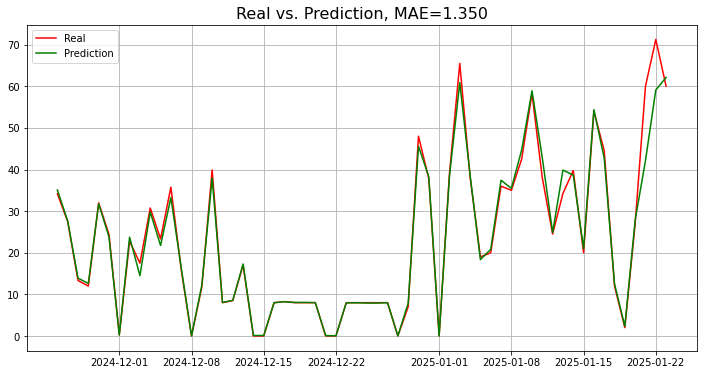

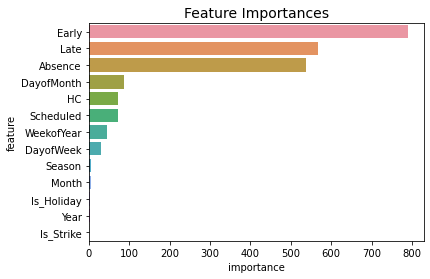

MAE without lags = 1.350


In [22]:

def train_time_series(df, target='Total_Lost', horizon=30):
    """
    Trains an LGBMRegressor on time series data, splitting the last `horizon` rows as the test set.
    """
    # 1) Separate features and target
    X = df.drop(columns=[target])
    y = df[target]
    
    # 2) Split train/test by last 'horizon' rows
    X_train, X_test = X.iloc[:-horizon, :], X.iloc[-horizon:, :]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
    
    # 3) Train LGBM with tuned hyperparameters and early stopping
    model = LGBMRegressor(
        random_state=42, 
        learning_rate=0.05, 
        n_estimators=1000, 
        max_depth=7, 
        num_leaves=31,
        verbose=-1  # Suppress LightGBM output
    )
    
    # Use early stopping
    model.fit(
        X_train, y_train, 
        eval_set=[(X_test, y_test)], 
        callbacks=[early_stopping(stopping_rounds=50, verbose=-1)]
    )
    
    # 4) Predict on test
    preds = model.predict(X_test)
    
    # 5) Calculate MAE
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)

    # 6) Print evaluation metrics and averages
    print(f"R-squared (R2) score: {r2:.3f}")
    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
    print(f"Average of Actual Total_Lost: {y_test.mean():.3f}")
    print(f"Average of Predictions Total_Lost: {preds.mean():.3f}")
    
    # 7) Plot Real vs Prediction
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test.values, label='Real', color='red')
    plt.plot(y_test.index, preds, label='Prediction', color='green')
    plt.title(f"Real vs. Prediction, MAE={mae:.3f}", fontsize=16)
    plt.legend()
    plt.grid()
    plt.show()
    
    # 8) Feature importances
    feat_imp = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    plt.title("Feature Importances", fontsize=14)
    sns.barplot(x='importance', y='feature', data=feat_imp, orient='h')
    plt.show()
    
    return model, mae

# Run the model
model_no_lags, mae_no_lags = train_time_series(df=df_grouped_test, target='Total_Lost', horizon=60)
print(f"MAE without lags = {mae_no_lags:.3f}")


# Scenario B: Create Lags & Model With Lags

Now we’ll add weekly (lag=7) and monthly (lag=30) lags for Absence, Early, and Late, just like you mentioned. Then we’ll repeat the train/test approach.

Shape after adding lags and dropping NaNs: (724, 22)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[120]	valid_0's l2: 8.15827
R-squared (R2) score: 0.977
Mean Squared Error (MSE): 8.158
Mean Absolute Error (MAE): 1.253
Root Mean Squared Error (RMSE): 2.856
Average of Actual Total_Lost: 23.145
Average of Predictions Total_Lost: 22.887


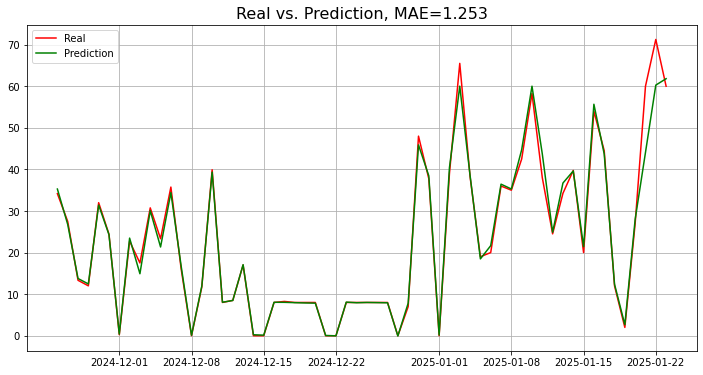

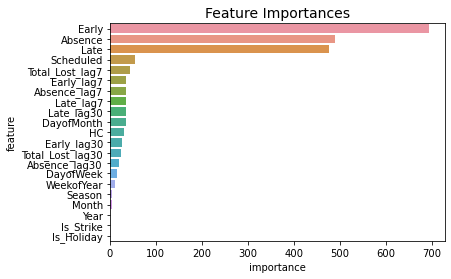

MAE with lags = 1.253


In [23]:
df_with_lags = df_grouped_test.copy()

# Create weekly lag (7 days) and monthly lag (30 days) for Absence, Early, Late


df_with_lags['Total_Lost_lag7']  = df_with_lags['Total_Lost'].shift(7)
df_with_lags['Total_Lost_lag30'] = df_with_lags['Total_Lost'].shift(30)

df_with_lags['Absence_lag7']  = df_with_lags['Absence'].shift(7)
df_with_lags['Absence_lag30'] = df_with_lags['Absence'].shift(30)

df_with_lags['Early_lag7']    = df_with_lags['Early'].shift(7)
df_with_lags['Early_lag30']   = df_with_lags['Early'].shift(30)

df_with_lags['Late_lag7']     = df_with_lags['Late'].shift(7)
df_with_lags['Late_lag30']    = df_with_lags['Late'].shift(30)

# Drop rows that became NaN due to shifting (first 30 days)
df_with_lags.dropna(axis=0, how='any', inplace=True)

print("Shape after adding lags and dropping NaNs:", df_with_lags.shape)

# Re-run train_time_series
model_with_lags, mae_with_lags = train_time_series(df=df_with_lags, 
                                                   target='Total_Lost',
                                                   horizon=60)

print(f"MAE with lags = {mae_with_lags:.3f}")

# 📊 **Model Performance and Readiness for Testing**

---

## ✅ **Key Observations**

Based on the observed **Mean Absolute Error (MAE)** and **feature importance analysis**, it is evident that:

- **Introducing lagged columns** has significantly **improved the model’s performance**, particularly in terms of:
  - **Feature relevance**
  - **Predictive power**

### 🔄 **Why Lagged Features Matter:**
- They provide **valuable context** by capturing **temporal patterns** and **trends**.
- This is essential for accurate **time series forecasting** as they:
  - Reflect **short-term dependencies** (e.g., yesterday’s absence).
  - Capture **seasonal effects** (e.g., weekly or monthly cycles).

---

## 🚀 **Readiness for Testing Phase**

Given the **enhanced model performance** with the inclusion of lag features, we are now ready to proceed to the:

- **Testing Phase** for **Absence predictions**.
- Ensuring that the model delivers **robust** and **reliable results**.

---

## ⚠️ **Important Note**

- The model currently demonstrates a **very high R² value** with **acceptable performance** because we **retained the following measures** in our dataset:
  - **Absence**
  - **Early**
  - **Late**

- These variables were included to **explore seasonality** during the **model development phase**.

### ❗ **Impact of Removing Absence, Early, and Late:**
- When these measures are **removed**:
  - The model’s performance **declines significantly**, especially in:
    - **R² score**
    - Other **evaluation metrics** (e.g., MAE, RMSE)
- This highlights the **critical role** these variables play in **capturing seasonality** and explaining **variations in absenteeism**.

---

## ⚙️ **Approach for Model Experimentation**

- For the **model experimentation process**, we will:
  - Use a **well-adjusted dataset** tailored for both **training** and **testing**.
  - Ensure that the dataset:
    - Maintains **relevant lagged features**.
    - Is structured to **balance performance** while minimizing dependence on unavailable future data.

---

> 💡 **Final Thought:**  
The **lagged features** have proven to be **crucial** for capturing temporal dependencies. Moving forward, we will focus on **refining** the dataset and **evaluating** the model’s robustness in different scenarios to ensure **consistent** and **accurate absenteeism predictions**. 🚀


In [24]:

#############
df['Strike'] = df['c_name_y'].str.contains('Strike', na=False).astype(int)
df['Waha']=df['Location Type'].str.contains('WAHA', na=False).astype(int)
df['Is_Holiday'] = df['Is_Holiday'].astype(int)
df['Is_Strike'] = df['Is_Strike'].astype(int)
#######
def prepare_dataframe(df,  mu_name='All'):
    groupbycols = [
        'Date', 'Year', 'Season', 'Month', 'WeekofYear',
        'DayofMonth', 'DayofWeek', 'Is_Strike'
    ]

    # Step 1: Filter the dataframe
    dfprep = df[df['Is_Actual'] == 'Actual']

    if  mu_name != 'All':
        dfprep = dfprep[(dfprep['MU_Name'] == mu_name)]

    # Step 2: Groupby and aggregate
    dfprep = dfprep.groupby(groupbycols, as_index=False).agg(
        Is_Holiday=('Is_Holiday', np.mean),  # Avg holiday % across countries
        HC=('CCMS_ID', 'size'),              # Headcount
        StrikeP=('Strike', np.mean),          # Strike participation %
        Waha=('Waha', np.mean),               # Waha employee %
        Scheduled=('Scheduled', np.sum),      # Scheduled hours sum
        Worked=('Worked', np.sum),            # Worked hours sum
        Overtime=('Overtime', np.sum),        # Overtime hours sum
        Training=('Training', np.sum),        # Training hours sum
        Vacation=('Vacation', np.sum),        # Vacation hours sum
        Sick=('Sick', np.sum),                # Sick hours sum
        Total_Lost=('Total_Lost', np.sum),    # Total lost = Absence + Early + Late
        Absence=('Absence', np.sum),          # Absence hours sum
        Early=('Early', np.sum),              # Early leaving hours sum
        Late=('Late', np.sum)                 # Late arrivals sum
    ).reset_index(drop=True)

    # Step 3: Define columns for rolling sums
    rolling_columns = ['Total_Lost', 'Absence', 'Early', 'Late','Scheduled', 'Worked', 'Training', 'Vacation', 'Sick']

    # Step 4: Define rolling windows
    rolling_windows = {
        '1W': 7,    # Last 1 week
        '1M': 30,   # Last 1 Month
    }

    # Step 5: Sort by date before rolling calculations
    dfprep = dfprep.sort_values(by=['Date'])

    # Step 6: Compute rolling sums with 1-week delay
    for window_label, window_size in rolling_windows.items():
        for col in rolling_columns:
            dfprep[f'{col}_RollingSum_{window_label}'] = (
                dfprep[col].shift(7)  # Shift by 7 days to delay calculation
                .rolling(window=window_size, min_periods=1)
                .sum()
                .reset_index(drop=True)
            )
    # Step 6: Compute rolling AVG with 1-week delay
    for window_label, window_size in rolling_windows.items():
        for col in rolling_columns:
            dfprep[f'{col}_RollingAVG_{window_label}'] = (
                dfprep[col].shift(7)  # Shift by 7 days to delay calculation
                .rolling(window=window_size, min_periods=1)
                .mean()
                .reset_index(drop=True)
            )
    # Step 7: Convert 'Date' to datetime and set index
    dfprep['Date'] = pd.to_datetime(dfprep['Date'])
    dfprep = dfprep.set_index('Date')

    # Step 8: Overwrite columns based on index
    dfprep['Year'] = dfprep.index.year
    dfprep['Month'] = dfprep.index.month
    dfprep['DayofMonth'] = dfprep.index.day
    dfprep['DayofWeek'] = dfprep.index.dayofweek  # Monday=0, Sunday=6
    dfprep['WeekofYear'] = dfprep.index.isocalendar().week

    # Step 9: Create lagged features
    lag_days = [7,30]
    for lag in lag_days:
        for col in ['Scheduled', 'Worked','Total_Lost', 'Absence', 'Early', 'Late', 'Training', 'Vacation', 'Sick']:
            dfprep[f'{col}_lag{lag}'] = dfprep[col].shift(lag)

    # Step 10: Drop rows with NaN values introduced by shifting
    dfprep.dropna(axis=0, how='any', inplace=True)

    # Step 11: Drop unnecessary columns
    drop_cols = ['Absence', 'Early', 'Late', 'Worked', 'Training', 'Vacation', 'Sick','Overtime',]
    dfprep.drop(columns=drop_cols, inplace=True)
    
    dfprep['Month_sin'] = np.sin(2 * np.pi * dfprep['Month'] / 12)
    dfprep['Month_cos'] = np.cos(2 * np.pi * dfprep['Month'] / 12)
    dfprep['DayofWeek_sin'] = np.sin(2 * np.pi * dfprep['DayofWeek'] / 7)
    dfprep['DayofWeek_cos'] = np.cos(2 * np.pi * dfprep['DayofWeek'] / 7)
    dfprep['DayofMonth_sin'] = np.sin(2 * np.pi * dfprep['DayofMonth'] / 31)
    dfprep['DayofMonth_cos'] = np.cos(2 * np.pi * dfprep['DayofMonth'] / 31)

    
    return dfprep

# Example usage with default 'All' filters
processed_df = prepare_dataframe(df)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's l2: 242.982
R-squared (R2) score: 0.368
Mean Squared Error (MSE): 242.982
Mean Absolute Error (MAE): 13.931
Root Mean Squared Error (RMSE): 15.588
Average of Actual Total_Lost: 38.964
Average of Predictions Total_Lost: 36.791


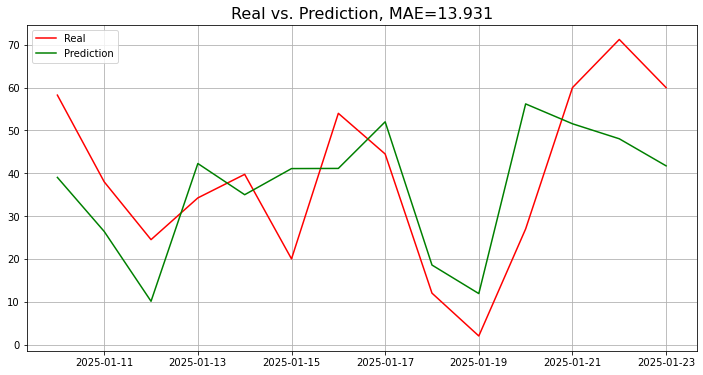

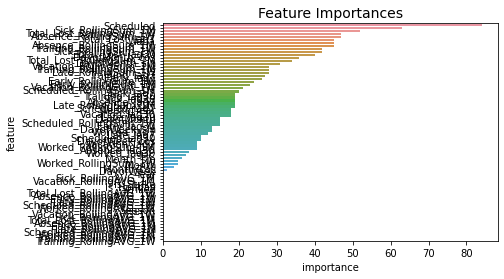

MAE with lags = 13.931


In [25]:
# Re-run train_time_series
model_with_lags, mae_with_lags = train_time_series(df=processed_df, 
                                                   target='Total_Lost',
                                                   horizon=14)

print(f"MAE with lags = {mae_with_lags:.3f}")